# DeepLearning 미션 난이도(상)-2-3
## Semi-supervised learning을 이용한 오토 인코더 훈련에 대해 이해하기 및 구현하기

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import sys
import os

import torch
import torchvision
import torchvision.transforms as T
from torchsummary import summary

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import wandb

In [2]:
# seed 고정
import random
import torch.backends.cudnn as cudnn

def random_seed(seed_num):
    torch.manual_seed(seed_num)
    torch.cuda.manual_seed(seed_num)
    torch.cuda.manual_seed_all(seed_num)
    cudnn.benchmark = False
    cudnn.deterministic = True
    random.seed(seed_num)

random_seed(42)

## Data

In [3]:
tranform = T.Compose([
    T.ToTensor()
])

train_dataset = torchvision.datasets.MNIST(root='./MNIST_DATASET', train=True, download=True, transform=tranform)
test_dataset = torchvision.datasets.MNIST(root='./MNIST_DATASET', train=False, download=True, transform=tranform)

In [4]:
# labeled, unlabeled 데이터 분할
total_num = len(train_dataset)
labeled_num, unlabeled_num = int(total_num*0.2), int(total_num*0.8)

labeled_train_dataset, unlabeled_train_dataset = torch.utils.data.random_split(train_dataset, [labeled_num, unlabeled_num])

In [5]:
batch_size = 32

labeled_train_dataloader = torch.utils.data.DataLoader(labeled_train_dataset, batch_size=batch_size, shuffle=True)
unlabeled_train_dataloader = torch.utils.data.DataLoader(unlabeled_train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

## Model

### AutoEncoder

In [6]:
class Autoencoder(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(28*28, 128),
            torch.nn.ReLU(True),
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(True),
            torch.nn.Linear(64, 12),
            torch.nn.ReLU(True),
            torch.nn.Linear(12, 3)
        )

        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(3, 12),
            torch.nn.ReLU(True),
            torch.nn.Linear(12, 64),
            torch.nn.ReLU(True),
            torch.nn.Linear(64, 128),
            torch.nn.ReLU(True),
            torch.nn.Linear(128, 28*28),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)

        return encoded, decoded

### Classifier

In [7]:
class Classifier(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(3, 10),
            torch.nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        return self.classifier(x)

## model 생성 및 학습

In [8]:
autoencoder = Autoencoder()
classifier = Classifier()

ae_criterion = torch.nn.MSELoss()
clf_criterion = torch.nn.NLLLoss()

ae_optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001)
clf_optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)

In [9]:
def ae_training(model, unlabeled_train_dataloader, unlabeled_train_dataset, ae_criterion, ae_optimizer):
    model.train()

    tbar = tqdm(unlabeled_train_dataloader)
    for images, labels in tbar:
        y = images.view(-1, 28*28) # 원본 데이터
        encoded, decoded = model(images) # 모델에서 결과를 반환받는다.
        loss = ae_criterion(decoded, y) # loss 계산: 재생성 데이터와 원본 데이터 비교

        ae_optimizer.zero_grad()
        loss.backward()
        ae_optimizer.step()

    return model

def clf_training(model, ae_model, labeled_train_dataloader, labeled_train_dataset, clf_criterion, clf_optimizer):
    model.train()
    train_loss = 0.0
    train_accuracy = 0

    tbar = tqdm(labeled_train_dataloader)
    for images, labels in tbar:
        encoded, _ = ae_model(images)
        outputs = model(encoded)
        loss = clf_criterion(outputs, labels)

        clf_optimizer.zero_grad()
        loss.backward()
        clf_optimizer.step()

        train_loss += loss.item()
        max_prob, predicted = torch.max(outputs, 1)
        train_accuracy += (predicted == labels).sum().item()

    train_loss = train_loss / len(labeled_train_dataloader)
    train_accuracy = train_accuracy / len(labeled_train_dataset)

    return model, train_loss, train_accuracy

In [10]:
def ae_training_loop(model, unlabeled_train_dataloader, unlabeled_train_dataset, ae_criterion, ae_optimizer, num_epochs):
    for epoch in range(num_epochs):
        model = ae_training(model ,unlabeled_train_dataloader, unlabeled_train_dataset, ae_criterion, ae_optimizer)

    return model

def clf_training_loop(model, ae_model, labeled_train_dataloader, labeled_train_dataset, clf_criterion, clf_optimizer, num_epochs):
    for epoch in range(num_epochs):
        model, train_loss, train_accuracy = clf_training(model, ae_model, labeled_train_dataloader, labeled_train_dataset, clf_criterion, clf_optimizer)
        print(f'Train Loss: {train_loss}, Train Accuracy: {train_accuracy}')

    return model

In [11]:
# Autoencoder 모델 학습
ae_model = ae_training_loop(autoencoder, unlabeled_train_dataloader, unlabeled_train_dataset, ae_criterion, ae_optimizer, 10)

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

In [12]:
# Classifier 모델 학습
# 입력 데이터는 Autoencoder를 통해 생성된 encoded 결과

clf_model = clf_training_loop(classifier, ae_model, labeled_train_dataloader, labeled_train_dataset, clf_criterion, clf_optimizer, 15)

  0%|          | 0/375 [00:00<?, ?it/s]

Train Loss: 2.5980201574961344, Train Accuracy: 0.2505


  0%|          | 0/375 [00:00<?, ?it/s]

Train Loss: 1.445521418730418, Train Accuracy: 0.482


  0%|          | 0/375 [00:00<?, ?it/s]

Train Loss: 1.2016723421414692, Train Accuracy: 0.6030833333333333


  0%|          | 0/375 [00:00<?, ?it/s]

Train Loss: 1.1005441776911418, Train Accuracy: 0.6623333333333333


  0%|          | 0/375 [00:00<?, ?it/s]

Train Loss: 1.0377925821940104, Train Accuracy: 0.70025


  0%|          | 0/375 [00:00<?, ?it/s]

Train Loss: 0.9933625491460164, Train Accuracy: 0.71025


  0%|          | 0/375 [00:00<?, ?it/s]

Train Loss: 0.9591350154876709, Train Accuracy: 0.7243333333333334


  0%|          | 0/375 [00:00<?, ?it/s]

Train Loss: 0.9324499789873759, Train Accuracy: 0.7325833333333334


  0%|          | 0/375 [00:00<?, ?it/s]

Train Loss: 0.9110013618469238, Train Accuracy: 0.7351666666666666


  0%|          | 0/375 [00:00<?, ?it/s]

Train Loss: 0.8937201925913493, Train Accuracy: 0.7405833333333334


  0%|          | 0/375 [00:00<?, ?it/s]

Train Loss: 0.879629117568334, Train Accuracy: 0.7439166666666667


  0%|          | 0/375 [00:00<?, ?it/s]

Train Loss: 0.8682286052703857, Train Accuracy: 0.74425


  0%|          | 0/375 [00:00<?, ?it/s]

Train Loss: 0.8582043540477753, Train Accuracy: 0.74875


  0%|          | 0/375 [00:00<?, ?it/s]

Train Loss: 0.850229967435201, Train Accuracy: 0.74975


  0%|          | 0/375 [00:00<?, ?it/s]

Train Loss: 0.8432534557183583, Train Accuracy: 0.751


# Test
1. autoencoder 모델을 통해 encoded 결과를 반환
2. encoded 값을 classifier에 넣어서 결과 확인

In [21]:
ae_model.eval()
clf_model.eval()

test_loss = 0.0
test_accuracy = 0

total_labels = []
total_images = []
pred_labels = []

with torch.no_grad():
    tbar = tqdm(test_dataloader)
    for images, labels in tbar:
        total_images.extend(images)
        total_labels.extend(labels)
        encoded,decoded = ae_model(images)
        outputs = clf_model(encoded)

        loss = clf_criterion(outputs, labels)
        
        test_loss += loss.item()
        max_prob, predicted = torch.max(outputs, 1)
        test_accuracy += (labels == predicted).sum().item()

        pred_labels.extend(predicted)

test_loss = test_loss / len(test_dataloader)
test_accuracy = test_accuracy / len(test_dataset)

  0%|          | 0/313 [00:00<?, ?it/s]

In [17]:
print(test_loss)
print(test_accuracy)

0.8529981592783151
0.7446


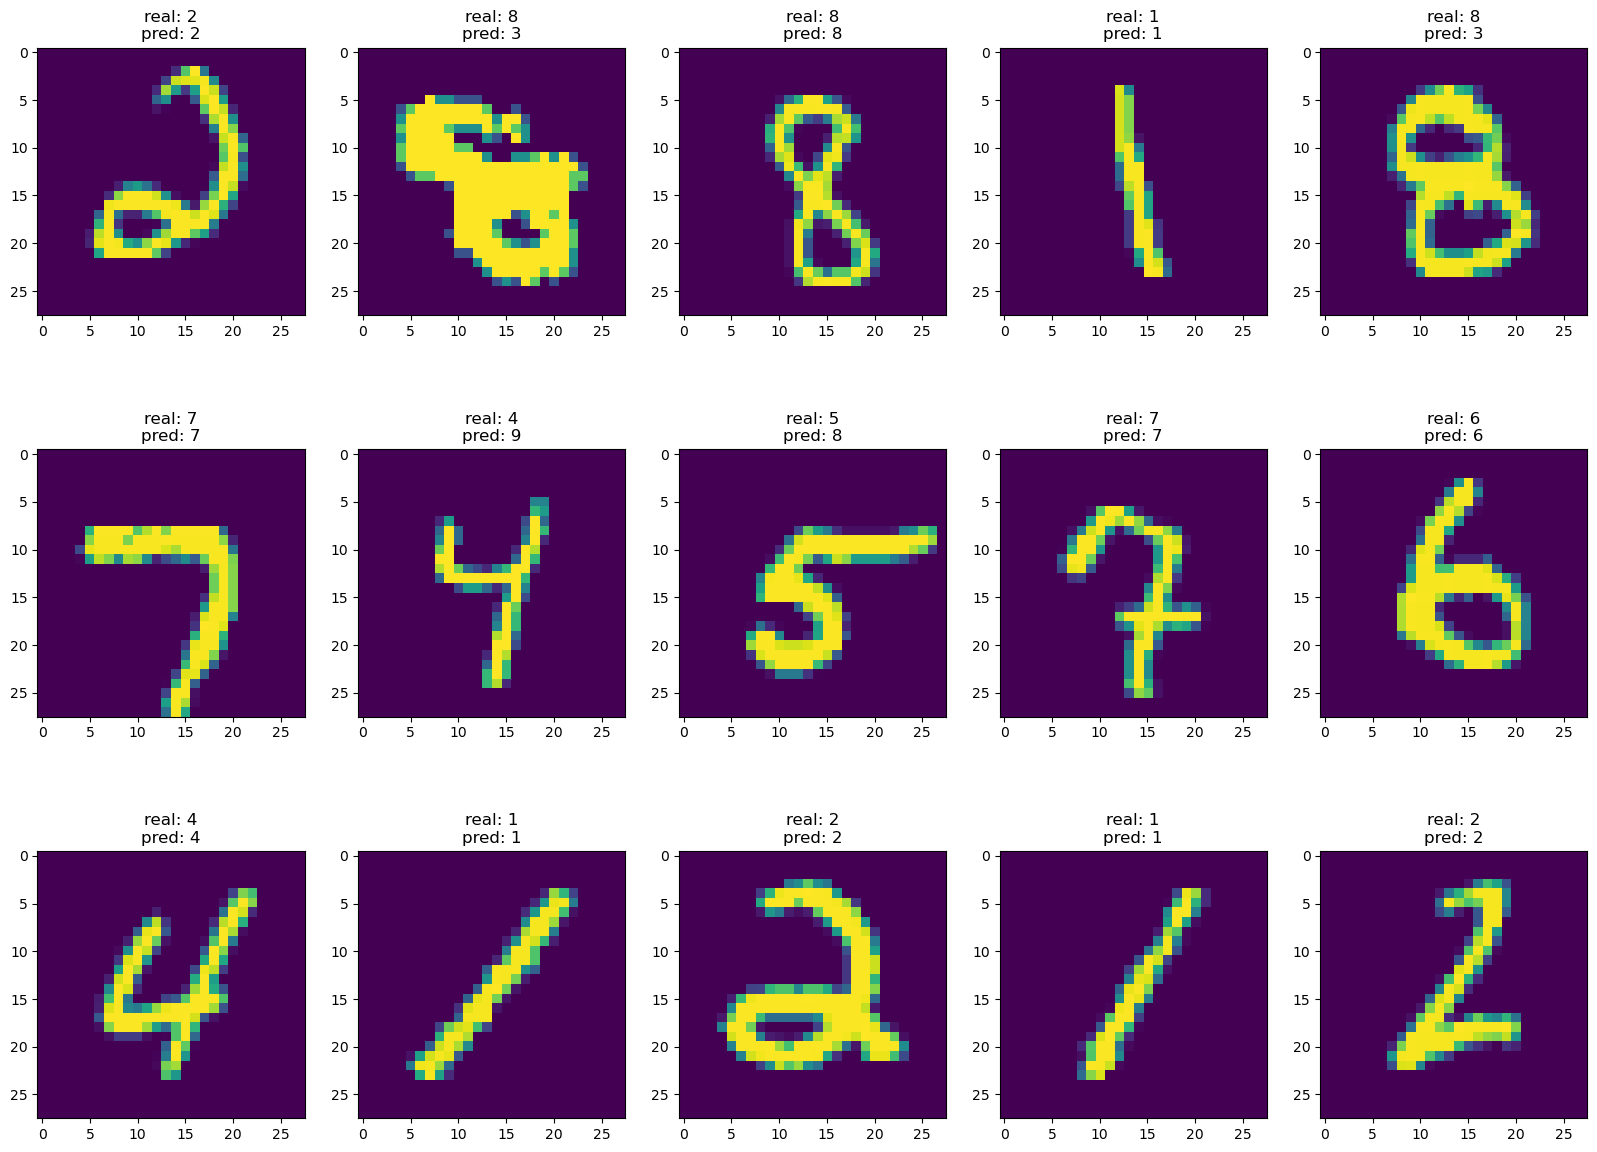

In [22]:
plt.figure(figsize=(20, 20))

for i in range(15):
    ax = plt.subplot(4, 5, i+1)
    plt.imshow(total_images[i][0])
    plt.title(f'real: {total_labels[i]}\npred: {pred_labels[i]}')